## Installation

When working within Google Colab, additional packages is necessary to take full advantage of the library. To install these, execute the following command:

In [ ]:
%pip install mrcfile tensorflow-graphics umap-learn wandb ipyvolume -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.2/687.2 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [ ]:
%pip install tensorflow_similarity -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


To begin using the dataset with our codebase in Colab, you first need to download it to your environment. In this tutorial, we'll proceed under the assumption that the dataset is stored on Google Drive. The following steps will guide you through the process of transferring the dataset from Google Drive to the local disk space provided by Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE = "/content/drive/MyDrive/protein-reconstruction/data/data/ribosome_real/"
DATASET_PATH = ""

In [ ]:
# The path pointed to cryoforum packages
ROOT_DIR = '/content/drive/MyDrive/protein-reconstruction/'

In [ ]:
!cp {DRIVE}/X_real.npy .
!cp {DRIVE}/y_real.npy .
!cp {DRIVE}/mrali2d.mrcs .
!cp {DRIVE}/70s_real_128_mrali_cs.star .
!cp {DRIVE}/indices.npz .

> If you're executing this on a local machine, you should directly specify the path to where your dataset resides by setting the `DATASET_PATH`. For instance, if your dataset is located in the directory `/home/username/cryoforum/data/ribosome_real/`, you would assign this path to the variable like so: `DATASET_PATH = "/home/username/cryoforum/data/ribosome_real/"`.

## Prepare the datasets

In [ ]:
import mrcfile
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append(ROOT_DIR)

from cryoem.utils_ascep import visualise_images, Starfile

For real datasets, one can import picked particles from software like `RELION` or `cryoSPARC`, which store metadata in `.star` files and particle images in `.mrcs` files.

Given the focus of this study on orientation recovery, it is advisable to execute a preliminary centering using alignment methods from `XMIPP` or similar packages. Additionally, `cryoSPARC` can be employed to create an initial 3D density map from particle images with higher confidence. The orientations extracted during this process serve as the ground truth for training and validation sets.

In [ ]:
s = Starfile.load(DATASET_PATH+'70s_real_128_mrali_cs.star')
df = s.df

In [ ]:
df

,_rlnImageName,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi,_rlnOriginXAngst,_rlnOriginYAngst,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle,_rlnPhaseShift,_rlnCtfBfactor,_rlnOpticsGroup,_rlnRandomSubset,_rlnClassNumber
0,000001@mrali2d.mrcs,-62.022282,36.458099,-67.620079,-7.503844,9.909656,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
1,000002@mrali2d.mrcs,-55.352402,109.262054,2.278171,-9.565969,-1.890281,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
2,000003@mrali2d.mrcs,-53.716774,108.314835,-64.747879,-4.639781,6.587344,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
3,000004@mrali2d.mrcs,-158.893433,8.793731,66.887657,-2.119406,1.546594,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
4,000005@mrali2d.mrcs,23.932434,72.908508,-100.426613,0.171844,9.107718,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,004996@mrali2d.mrcs,106.086182,13.631647,14.110674,3.379594,4.868906,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,2,1
4996,004997@mrali2d.mrcs,-47.166718,66.783211,7.325693,-7.160156,12.544594,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,1,1
4997,004998@mrali2d.mrcs,-76.714745,118.091339,-67.364357,-0.057281,7.274719,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,2,1
4998,004999@mrali2d.mrcs,-35.028847,52.562962,-91.533043,-6.358219,1.890281,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,1,1


Now, we convert the unit of Euler angles to radian:

In [ ]:
theta1 = df['_rlnAngleRot'].astype(float).values/360*2*np.pi
theta2 = df['_rlnAngleTilt'].astype(float).values/360*2*np.pi
theta3 = df['_rlnAnglePsi'].astype(float).values/360*2*np.pi

angles_true = np.stack((theta3, theta2, theta1), axis=-1)

In [ ]:
y = np.array(angles_true, dtype=np.float32)

In [ ]:
mrc = mrcfile.open(DATASET_PATH+'mrali2d.mrcs')
X = mrc.data

In [ ]:
visualise_images(X, 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

To complete the process, save the training data in the `.npy` format and write it to the disk:

In [ ]:
np.save('X_real.npy', X)
np.save('y_real.npy', y)

In [ ]:
DATA_PATH = "/content/drive/MyDrive/protein-reconstruction/data/"

In [ ]:
!cp X_real.npy {DATA_PATH}
!cp y_real.npy {DATA_PATH}

## Learning the Orientation Recovery Function

Next, we'll import the necessary packages into our working environment. This sets the stage for utilizing the functionalities these packages offer throughout our script:

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from time import strftime
import pathlib
import io
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import wandb
import mrcfile

sys.path.append(ROOT_DIR)

# From the code base
from cryoem.conversions import quaternion2euler, euler2quaternion, d_q, SO3_to_s2s2, s2s2_to_SO3, matrix2quaternion, euler2matrix, matrix2euler, euler2matrix
from cryoem.plots import plot_dP_dQ
from cryoem.helpers import train_val_test_split, projections_preprocessing, OneCycleLr, visualise_images, AttrDict, convert_Avec_to_A_psd, convert_Avec_to_A, DataGenerator_SO3, WeightAdjuster,\
                convert_Avec_to_A, convert_Avec_to_A_psd, WeightAdjuster, find_learning_rate, plot_lr_vs_loss, window_mask
from cryoem.layers import BlurLayer, BlurLayer2, GeneralizedMeanPooling2D2
from cryoem.losses import cosine_distance, cos_dist_output_shape, d_q2, d_q3, cus_loss, cus_loss_function, cus_mae, cus_loss2, quat_chordal_squared_loss
from cryoem.utils_ascep import visualise_images, Starfile


# From the tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten, AlphaDropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
#import tensorflow_similarity as tfsim
from tensorflow_similarity.layers import GeneralizedMeanPooling2D
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1141110408741334637
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1079229994894060625
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Reading the data

Begin by loading the images and establishing the hyperparameters for the project. A custom `AttrDict` class has been implemented to create a configuration structure. This allows developers to modify and access configuration settings in a flexible and user-friendly manner:

In [ ]:
config = dict(
    X_file = "X_real.npy",
    y_file = "y_real.npy",
    image_width = 128,
    image_height = 128,
    batch_size = 256,
    model = 'vgg_like',
    model_name = 'model_70sreal',
    epochs = 50,
    learning_rate = 0.001,
    lr_schedule = '1cycle',
    optimizer = 'adam',
    L2_reg = 0.001,
    Drop_rate = 0.3,
    Sampler = 'uniform',
    Sample_percent_train = 0.05,
    Sample_percent_val = 0.05,
    BlurType = 1,
    loss_fn = 'QCQP_dist',
    Weight_schedule = True,
    exp_const = 0.5,
    gap_exp_const = 6.0,
    window = True,
    norm = True,
    log = False,
    flatten = 3
)

The parameters provided are outlined with their respective meanings below:

- **`X_file`**: File containing the 2D Cryo-EM images.
- **`y_file`**: File with the ground truth Euler angles in radians.
- **`image_width`**: Specifies the width of the images.
- **`image_height`**: Specifies the height of the images.
- **`batch_size`**: Size of the batches used during training. A larger batch size may be beneficial for contrastive learning.
- **`model`**: The architecture to be used for the model. Currently defaults to a VGG-like network as the backbone and is not configurable.
- **`model_name`**: Designation for the trained model, used when saving to disk.
- **`learning_rate`**: The initial learning rate for training.
- **`lr_schedule`**: The strategy for learning rate scheduling; a one-cycle policy is standard for achieving superconvergence.
- **`optimizer`**: Defines the optimizer, with the option to switch to `RMSProp`.
- **`L2_reg`**: The L2 regularization parameter, which imposes penalties on weight magnitudes. If overfitting is observed, increase this value; if the model underfits the training data, reduce it.
- **`Drop_rate`**: The dropout rate, a regularization technique used in network layers to prevent overfitting. Elevate this rate if overfitting is detected, or lower it to allow the model to better fit the training data.
- **`Sampler`**: Selects the sampling method for creating training pairs, with options of `random` or `uniform`. Empirical evidence suggests that the `uniform` option tends to yield better results with real datasets.
- **`Sample_percent_train`**: The fraction of total pairs allocated for the training set.
- **`Sample_percent_val`**: The fraction of total pairs allocated for the validation set.
- **`BlurType`**: The type of preprocessing layer; `0` for none, `1` for a low-pass filter, and `2` for Gaussian blurring.
- **`loss_fn`**: Specifies the loss function; options include `Q_dist` for quaternion distances, `S2S2_dist` for 6D angle representation, and `QCQP_dist` for our modified QCQP approach.
- **`Weight_schedule`**: Activates beta scheduling for balancing two different loss functions when set to `True`. It is recommended to keep this setting as `True`.
- **`exp_const`**: Adjusts the exponent constant for weight scheduling. Increase this value to emphasize the importance of pair-wise distance in the early iterations of training.
- **`gap_exp_const`**: Determines the behavior of the `GeneralizedMeanPooling2D` layer. As `gap_exp_const` approaches infinity, the pooling becomes more like max pooling, whereas a value close to 1 yields average pooling.
- **`window`**: Enables a windowing function on the images to mitigate background noise when set to `True`. It is advisable to maintain this setting as `True`.
- **`norm`**: Standardizes images before training if `True`. We suggest to remain `True`.
- **`log`**: Activates Weights and Bias logging of training information if `True`.
- **`flatten`**: Determines the layer between the CNN backbone and regression head; `0` for flattening, `1` for Global Max Pooling, `2` for combining Global Max and Average Pooling, and `3` for Generalized Mean Pooling.

In [ ]:
config = AttrDict(config)
# Initialize the W&B run
if config.log:
  wandb.login()
  from wandb.keras import WandbCallback
  run = wandb.init(project='vgg_exp', config=config, job_type='train', reinit=True, entity="sabid")
  config = wandb.config

In [ ]:
config

{'X_file': 'X_real.npy',
 'y_file': 'y_real.npy',
 'image_width': 128,
 'image_height': 128,
 'batch_size': 256,
 'model': 'vgg_like',
 'model_name': 'model_70sreal',
 'epochs': 50,
 'learning_rate': 0.001,
 'lr_schedule': '1cycle',
 'optimizer': 'adam',
 'L2_reg': 0.001,
 'Drop_rate': 0.3,
 'Sampler': 'uniform',
 'Sample_percent_train': 0.05,
 'Sample_percent_val': 0.05,
 'BlurType': 1,
 'loss_fn': 'QCQP_dist',
 'Weight_schedule': True,
 'exp_const': 0.5,
 'gap_exp_const': 6.0,
 'window': True,
 'norm': True,
 'log': False,
 'flatten': 3}

We begin by loading the Cryo-EM images and the corresponding ground truth angles. Subsequently, the angles are converted into 3D rotation matrices, facilitating easier computation of loss across differing angle representations:

In [ ]:
X = np.load(DATASET_PATH+config.X_file)
y = np.load(DATASET_PATH+config.y_file)

In [ ]:
y = euler2matrix(y)
y = y.numpy()

We load predefined splits for training, validation, and testing to enhance reproducibility. Alternatively, you can exclude the `file_name` parameter to create new splits for different datasets:

In [ ]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(X.shape[0]), file_name="indices.npz")

In [ ]:
len(train_idx), len(val_idx), len(test_idx)

(2512, 838, 1650)

In [ ]:
X.shape, y.shape

((5000, 128, 128), (5000, 3, 3))

Visualize the raw images by employing the `visualise_images()` function:

In [ ]:
visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

Prior to training, we preprocess the images using the following steps:

In [ ]:
if config.window:
  X = X.squeeze()
  X = X*window_mask(config.image_height, 0.85, 0.99)
  X = np.expand_dims(X, -1)

In [ ]:
if config.norm:
  X = X.squeeze()
  norm  = [np.mean(X), np.std(X)]
  X = (X - norm[0])/norm[1]
  X = np.expand_dims(X, -1)

To inspect the results of the preprocessing, visualize the preprocessed images:

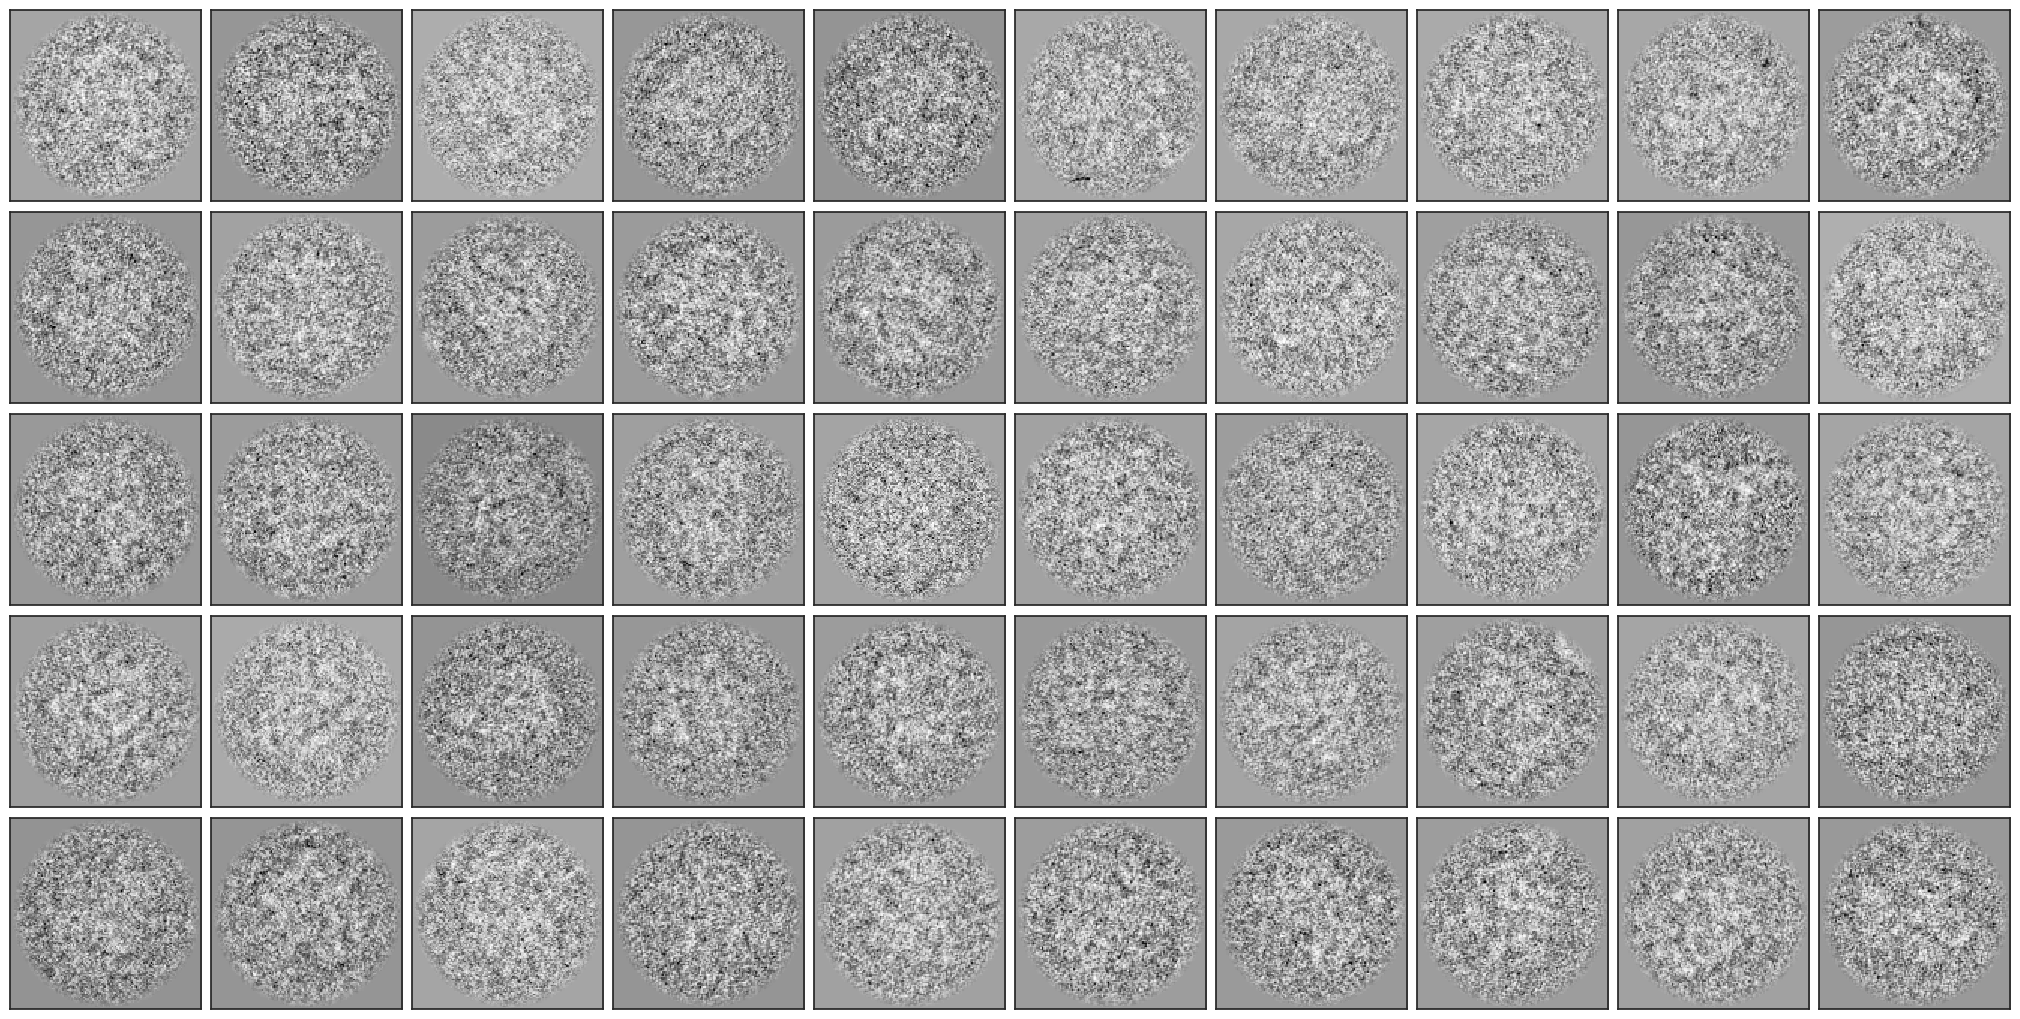

In [ ]:
visualise_images(X.squeeze(), 50 , 10, False)

### Define the Model

Now that the preliminary steps are complete, it's time to define our CNN backbone and the regression head. The network architecture can be modified as needed to explore different experimental setups:

In [ ]:
model = None

def create_siamese_network_ori(input_shape, config):
    """Base network to be shared (eq. to feature extraction)."""
    l2=tf.keras.regularizers.l2(config.L2_reg)
    input_x = Input(shape=input_shape)
    if config.BlurType == 1:
      x = BlurLayer(5, config.image_width)(input_x)
    elif config.BlurType == 2:
      x = BlurLayer2(5, 11)(input_x)
    else:
      x = input_x
    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(64, [5, 5], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(1024, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(1024, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    if config.flatten == 0:
      f = Flatten()(x)
    elif config.flatten == 1:
      f = tf.keras.layers.GlobalMaxPooling2D()(x)
    elif config.flatten == 2:
      f1 = tf.keras.layers.GlobalAveragePooling2D()(x)
      f2 = tf.keras.layers.GlobalMaxPooling2D()(x)
      f =  tf.keras.layers.Concatenate()([f1, f2])
    else:
      f = GeneralizedMeanPooling2D(p=config.gap_exp_const)(x)

    if config.loss_fn == "Q_dist":
      final = Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      A = final
    elif config.loss_fn == "S2S2_dist":
      final = Dense(6, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      A = final
    elif config.loss_fn == "QCQP_dist":
      ### Gram-Schmidt Orthognalize
      x  = Dense(10, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      #c1 = tf.math.l2_normalize(x[:, :3], axis=-1)
      #c2 = tf.math.l2_normalize(x[:, 3:] - tfdot(c1,x[:, 3:])*c1, axis=-1)
      #final = tf.concat([c1,c2], axis=-1)


      ### QCQP
      A = convert_Avec_to_A_psd(x)
      _, evs = tf.linalg.eigh(A)
      final = tf.squeeze(evs[:,:,0])
      #final = tf.keras.activations.tanh(final)
      #final = tfsim.layers.ActivationStdLoggingLayer(name="out_std")(final)


    return Model(input_x, [A, final], name='cnn')

The training function is set to automatically retrieve parameters from the provided configuration structure by default:

In [ ]:
def train_siamese2(X, y, train_idx, val_idx, config, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    """Main method for learning the distance between two projections

    Parameters
    ----------
    X  : np.ndarray
        The array containing the projections.
    y : np.ndarray
        The array containing the ground-truth angles for every projections.
    train_idx : np.ndarray, list
        The list of training indices.
    val_idx : np.ndarray, list
        The list of validation indices.
    path_logs_training : str
        The path to logs.
    training_description : str
        Name for this training model.
    training_steps=None,
        The number of training steps.
    validation_steps=None,
        The number of validation steps.
    plot=True,
        To plot or not to plot.
    gpus=None
        Used for multi-gpu training.

    Returns
    -------
    model : keras model
        Learned distance model
    history1 : history
        Contains information about MAE, MSE losses
    """
    _idx1 = list(np.random.choice(val_idx, size=1000))
    _idx2 = list(np.random.choice(val_idx, size=1000))

    q1_true = euler2quaternion([y[i] for i in _idx1])
    q2_true = euler2quaternion([y[i] for i in _idx2])

    p1 = [X[i] for i in _idx1]
    p2 = [X[i] for i in _idx2]


    # Prepare data generators
    if config.Sampler == 'uniform':
      training_generator = DataGenerator_SO3(X, y, train_idx, config.loss_fn, limit_num_pairs=training_steps, limit_style='uniform', shuffle=True, batch_size=config.batch_size)
    else:
      training_generator = DataGenerator_SO3(X, y, train_idx, config.loss_fn, limit_num_pairs=training_steps, limit_style='random', shuffle=True, batch_size=config.batch_size)

    validation_generator = DataGenerator_SO3(X, y, val_idx, config.loss_fn, limit_num_pairs=validation_steps, limit_style='random', shuffle=False, batch_size=config.batch_size)

    input_shape = tuple(list(X.shape[1:]))
    print(f"Input images shape {input_shape}")

    # network definition
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    cnn_network = create_siamese_network_ori(input_shape, config)

    # because we re-use the same instance `cnn_network`,
    # the weights of the network will be shared across the two branches
    _, finala = cnn_network(input_a)
    _, finalb = cnn_network(input_b)

    #f = tf.keras.layers.Concatenate()([processed_a, processed_b])
    #l2=tf.keras.regularizers.l2(1e-3)
    #embed = tf.keras.layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2, use_bias=False)(f)
    #x = BatchNormalization()(embed)
    #x = tf.keras.layers.PReLU()(x)
    #x = Dropout(0.5)(x)
    #x = tf.keras.layers.Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(x)
    #distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

    global model
    if config.loss_fn == "QCQP_dist" or config.loss_fn == "SO3_dist" or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
      distance = Lambda(d_q3, output_shape=cos_dist_output_shape, name="distance")([finala, finalb])
      model = Model([input_a, input_b], [distance, finala, finalb])
    elif config.loss_fn == "QCQP_dist" or config.loss_fn == "SO3_dist" or config.loss_fn == "QCQP_direct" or config.loss_fn == "SO3_direct":
      model = Model([input_a, input_b], [finala, finalb])
    else:
      raise ValueError("This loss not yet implemented")
    # train
    cnn_network.summary()
    model.summary()

    # training only top layers
    #optimizer1 = RMSprop(learning_rate=learning_rate)
    optimizer1 = Adam(learning_rate=config.learning_rate, beta_2=0.99, epsilon=1e-05)
    #optimizer1 = Adam(learning_rate=learning_rate)
    if config.Weight_schedule:
      loss_weight1 = K.variable(1)
      loss_weight2 = K.variable(0)
      loss_weight3 = K.variable(0)
      loss_ws = [loss_weight1, loss_weight2, loss_weight3]

      # define the callback
      weight_adjuster = WeightAdjuster(
        loss_ws, config.epochs, config.exp_const  # Pass the weights list to callbacks
      )
      if config.loss_fn == "QCQP_dist" or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
        model.compile(loss=[cus_mae(loss_weight1), cus_loss(loss_weight2), cus_loss(loss_weight3)], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_dist":
        model.compile(loss=[cus_mae(loss_weight1), cus_mae(loss_weight2), cus_mae(loss_weight3)], optimizer=optimizer1, sample_weight_mode=None)
    else:
      if config.loss_fn == "QCQP_dist"or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), cus_loss_function, cus_loss_function], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_dist":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError()], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "QCQP_direct":
        model.compile(loss=[cus_loss_function, cus_loss_function], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_direct":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError()], optimizer=optimizer1, sample_weight_mode=None)


    one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=len(training_generator), epochs=config.epochs)#, cycle_momentum=False)#, anneal_strategy='linear')
    if config.Sampler == 'uniform':
      print('uniform')
      one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=len(training_generator), epochs=config.epochs)



    # Setup callbacks
    # Callback that saves the model
    training_description = training_description or strftime('%Y%m%d_%H%M%S')
    CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
    pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
    backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
    print(f"Model will be saved to: {CHECKPOINT_PATH}")

    # Callback that will show tensorboard data
    LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    #callbacks = [reduce_lr]
    #callbacks = [one_c]
    callbacks = [backup_callback, one_c]
    if config.log:
      callbacks.append(WandbCallback(save_model=True, monitor="val_loss", mode="min"))
    if config.Weight_schedule:
      callbacks.append(weight_adjuster)
    history1 = model.fit(training_generator,
                            epochs=config.epochs,
                            validation_data=validation_generator,
                            callbacks=callbacks)
                            #callbacks=[backup_callback, lr_scheduler, weight_adjuster])

    # Get training and test loss histories
    #training_loss = history1.history['loss']
    #val_loss = history1.history['val_loss']
    #pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
    #np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, history1)

    return model, history1, one_c

#### Inspecting the Architecture

Before commencing with training, it's important to verify that the input shapes align with our expectations and the architecture is correctly configured:

In [ ]:
input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

# network definition
input_a = Input(shape=input_shape)

cnn_network = create_siamese_network_ori(input_shape, config)
cnn_network.summary()

Input images shape (128, 128, 1)
Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 blur_layer (BlurLayer)      (None, 128, 128, 6)          16384     ['input_3[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         9408      ['blur_layer[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                

### Orientation Learning

Create a directory to store the trained model and associated metadata before initiating the training process:

In [ ]:
TRAINING_DIR = "real70s"

In [ ]:
!mkdir {TRAINING_DIR}

> When employing `random` in the sampler, consider reducing the `Sample_percent_train` to align the pairing distribution with that of `uniform`.

In [ ]:
train_percent = config.Sample_percent_train
val_percent = config.Sample_percent_val
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(315507, 35112)

In [ ]:
#l2 0.001 drop 0.3 uniform
model, history1, onec = train_siamese2(X=X, y=y,
                               train_idx=train_idx,
                               val_idx=val_idx,
                               config=config,
                               path_logs_training=TRAINING_DIR,
                               training_description=config.model_name,
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),
                               plot=False,
                               gpus=None)

min= 8326
total number of data =  66608
Data created in 7.149687767028809 sec
Data created in 0.5908200740814209 sec
Input images shape (128, 128, 1)
Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 blur_layer_1 (BlurLayer)    (None, 128, 128, 6)          16384     ['input_5[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 128, 128, 32)         9408      ['blur_layer_1[0][0]']        
                                                                                                  
 batch_normalization_10 (Ba  (None, 128, 128,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 lr:0.000050  mom:0.948923
261/261 [==============================] - 205s 652ms/step - loss: 8.8160 - distance_loss: 0.9422 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00 - val_loss: 9.9217 - val_distance_loss: 2.0777 - val_cnn_loss: 0.0000e+00 - val_cnn_1_loss: 0.0000e+00
Epoch 2/50
261/261 [==============================] - ETA: 0s - loss: 8.6933 - distance_loss: 0.9100 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00
Epoch 2: val_loss improved from 9.92171 to 9.79397, saving model to real70s/training/model_70sreal.h5
 lr:0.000081  mom:0.945708
261/261 [==============================] - 160s 611ms/step - loss: 8.6933 - distance_loss: 0.9100 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00 - val_loss: 9.7940 - val_distance_loss: 2.0884 - val_cnn_loss: 0.0000e+00 - val_cnn_1_loss: 0.0000e+00
Epoch 3/50
261/261 [==============================] - ETA: 0s - loss: 8.6236 - distance_loss: 0.7771 - cnn_loss: 0.1464 - cnn_1_loss: 0.1468
Epoch 3: val_loss improved from 9.79397 to 9.47001, savi

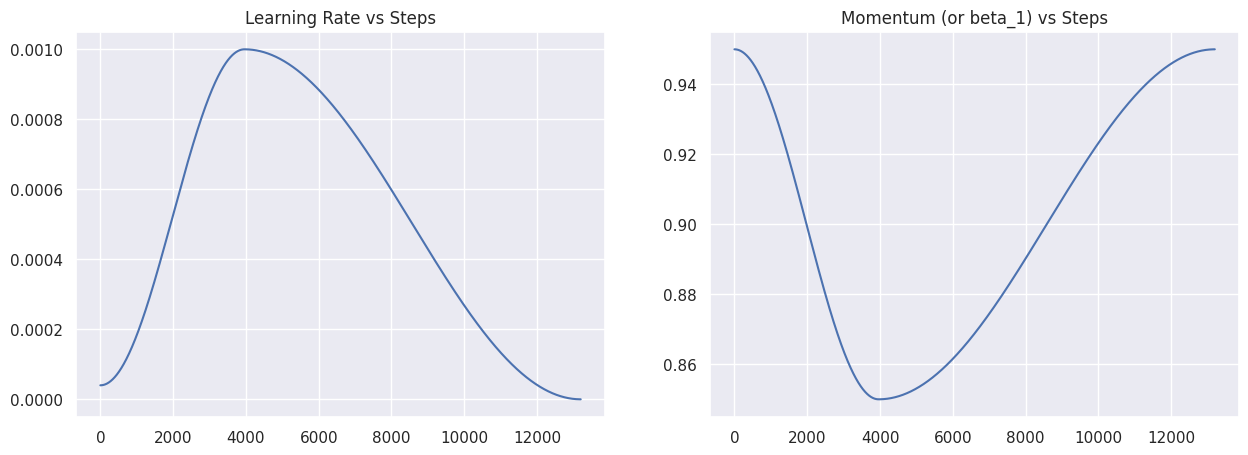

In [ ]:
sns.set_style("darkgrid", {"axes.grid":True})
onec.plot_lrs_moms()

### Read Model Checkpoint

At this stage, we have the option to save the trained model to disk for future use, or alternatively, we can load a pre-trained model from storage:

In [ ]:
# Load pretrained model
!cp /content/drive/MyDrive/protein-reconstruction/models/model_70sreal_qcqp_mra.h5 .

In [ ]:
# We can also save the model in the last iteration
# model.save("70sreal.h5") # one may choose to store the final model

In [ ]:
# Save the current model
# !cp {TRAINING_DIR}/training/{config.model_name}.h5 {ROOT_DIR}models/test.h5

In [ ]:
# put correct filename
#model_filename = TRAINING_DIR+"/training/"+config.model_name+".h5" # The current model
model_filename = "model_70sreal_qcqp_mra.h5" # The pretrained model

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename, compile=False, custom_objects={"BlurLayer": BlurLayer})

# Show the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 cnn (Functional)            [(None, 4, 4),               2018157   ['input_1[0][0]',             
                              None]                       8          'input_2[0][0]']             
                                                                                                  
 distance (Lambda)           (None,)                      0         ['cnn[0][1]',             

## Analysis

### Performance Plot - True vs. Predicted

We now proceed to utilize the trained model to make inferences on the training, validation, and test datasets:

In [ ]:
cnn = model.layers[-2]

In [ ]:
q_pred_train = cnn.predict(X[train_idx])[1]
q_pred_val = cnn.predict(X[val_idx])[1]
q_pred_test = cnn.predict(X[test_idx])[1]

52/52 [==============================] - 3s 52ms/step


After obtaining the predictions, we can compute the error metrics using the `d_q()` function to evaluate the model's performance:

In [ ]:
#vgg s2s2 1/2
c1 = d_q(q_pred_train, matrix2quaternion(y[train_idx]))
c2 = d_q(q_pred_val, matrix2quaternion(y[val_idx]))
c3 = d_q(q_pred_test, matrix2quaternion(y[test_idx]))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.015096221327275386,
 0.11362442459544489,
 0.11609790959352159,
 0.016817963884608676,
 0.47350160526201296,
 0.5019076155734106)

In [ ]:
#https://docs.wandb.ai/guides/track/log
#run.summary["training_error_median"] = np.median(c1)
#run.summary["validation_error_median"] = np.median(c2)
#run.summary["testing_error_median"] = np.median(c3)
#run.summary["training_error_mean"] = np.mean(c1)
#run.summary["validation_error_mean"] = np.mean(c2)
#run.summary["testing_error_mean"] = np.mean(c3)
#run

In [ ]:
#config.model_name, run.dir

In [ ]:
#model.save(os.path.join(run.dir, "70s/training/"+config.model_name+".h5"))

In [ ]:
#run.finish()

#### Uncertainty quantification with Matrix `A`

To quantify uncertainty in our model predictions, we establish several metrics as follows:

In [ ]:
from cryoem.uncertainty import max_dispersion_coeff, sum_bingham_dispersion_coeff, first_eig_gap, wigner_log_likelihood_measure

In [ ]:
def compute_threshold(A, uncertainty_metric_fn=first_eig_gap, quantile=0.75):
  stats = uncertainty_metric_fn(A)
  return np.quantile(stats, quantile)

In [ ]:
def _scatter(ax, x, y, title, color='tab:red', marker=".", size =4, rasterized=False):
    ax.scatter(x, y, color=color, s=size, marker=marker, label=title, rasterized=rasterized)
    return

def _create_scatter_plot(thresh, thresh_label, lls, errors, labels, xlabel, ylim=None, legend=True, ylabel=True):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,6)
    ax.axvline(thresh, c='k', ls='--', lw=0.75, label=thresh_label)
    colors = ['tab:orange','grey']
    markers = ['.', '+']
    for i, (ll, error, label) in enumerate(zip(lls, errors, labels)):
        _scatter(ax, ll, error, label, color=colors[i], size=1, marker=markers[i], rasterized=True)
    if legend:
        ax.legend(loc='upper left', markerscale=5.0, fontsize=14)
    ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
    if ylabel:
        ax.set_ylabel('Error', fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    #ax.set_yscale('log')
    #ax.set_xscale('symlog')
    #ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    ax.set_ylim(ylim)
    return fig

We will now extract the metrics from matrix `A` and compile them into a `DataFrame` for structured analysis and reporting:

In [ ]:
A_train = cnn.predict(X[train_idx])[0]
A_val = cnn.predict(X[val_idx])[0]
A_test = cnn.predict(X[test_idx])[0]

52/52 [==============================] - 2s 35ms/step


In [ ]:
lls = [max_dispersion_coeff(A_test), max_dispersion_coeff(A_train)]
lls2 = [sum_bingham_dispersion_coeff(A_test), sum_bingham_dispersion_coeff(A_train)]
lls3 = [first_eig_gap(A_test), first_eig_gap(A_train)]
lls4 = [wigner_log_likelihood_measure(A_test), wigner_log_likelihood_measure(A_train)]
errors = [d_q(q_pred_test, matrix2quaternion(y[test_idx])), d_q(q_pred_train, matrix2quaternion(y[train_idx]))]
df = pd.DataFrame([errors[0].numpy(), lls[0], lls2[0], lls3[0], lls4[0]]).T
df

,0,1,2,3,4
0,0.032947,-66.592560,-268.088531,66.592560,-4211.626953
1,0.033692,-66.177399,-246.040482,66.177399,-4009.309814
2,0.086451,-9.803192,-37.383157,9.803192,-81.512756
3,0.051705,-24.475382,-116.784574,24.475382,-765.767273
4,0.179096,-29.571880,-167.587105,29.571880,-1655.255371
...,...,...,...,...,...
1645,0.212867,-0.983990,-6.737435,0.983990,-2.823532
1646,0.178115,-57.978142,-284.914036,57.978142,-4576.940918
1647,1.540983,-0.039252,-0.467097,0.039252,-7.452115
1648,0.050873,-0.503966,-2.668908,0.503966,-3.064099


In [ ]:
df.describe()

,0,1,2,3,4
count,1650.000000,1650.000000,1650.000000,1650.000000,1.650000e+03
mean,0.501908,-145.251511,-646.040312,145.251511,-4.798501e+05
std,0.805325,628.763693,2813.534708,628.763693,3.395766e+06
min,0.006438,-7338.574707,-33406.016846,0.001072,-6.380487e+07
25%,0.063328,-38.308702,-167.464557,0.523882,-1.663374e+03
50%,0.116098,-7.675612,-37.501526,7.675612,-8.939669e+01
75%,0.429488,-0.523882,-3.781818,38.308702,-7.308408e+00
max,3.141128,-0.001072,-0.065642,7338.574707,-2.229257e+00


In [ ]:
np.quantile(errors[0].numpy(), 0.25), np.quantile(errors[0].numpy(), 0.5), np.quantile(errors[0].numpy(), 0.75)

(0.06332774961779644, 0.11609790959352159, 0.42948782516103434)

In [ ]:
df.columns = ['error', 'max', 'trace', 'gap', 'likelihood']

In [ ]:
mybins = pd.IntervalIndex.from_tuples([(0, np.quantile(errors[0].numpy(), 0.25)),
                    (np.quantile(errors[0].numpy(), 0.25), np.quantile(errors[0].numpy(), 0.5)),
                    (np.quantile(errors[0].numpy(), 0.5), np.quantile(errors[0].numpy(), 0.75)),
                    (np.quantile(errors[0].numpy(), 0.75), 3.14)])
df['testing error'] = pd.cut(df['error'], bins = mybins)
df['testing error'] = df['testing error'].apply(lambda x: x.right)
df

,error,max,trace,gap,likelihood,testing error
0,0.032947,-66.592560,-268.088531,66.592560,-4211.626953,0.063328
1,0.033692,-66.177399,-246.040482,66.177399,-4009.309814,0.063328
2,0.086451,-9.803192,-37.383157,9.803192,-81.512756,0.116098
3,0.051705,-24.475382,-116.784574,24.475382,-765.767273,0.063328
4,0.179096,-29.571880,-167.587105,29.571880,-1655.255371,0.429488
...,...,...,...,...,...,...
1645,0.212867,-0.983990,-6.737435,0.983990,-2.823532,0.429488
1646,0.178115,-57.978142,-284.914036,57.978142,-4576.940918,0.429488
1647,1.540983,-0.039252,-0.467097,0.039252,-7.452115,3.140000
1648,0.050873,-0.503966,-2.668908,0.503966,-3.064099,0.063328


In [ ]:
np.quantile(lls[0], 0.05), np.quantile(lls2[0], 0.05), np.quantile(lls3[0], 0.95)

(-351.97693939208983, -1546.1489736557005, 351.9769393920894)

Next, we'll create a scatter plot to visualize the relationship between the computed statistics and the testing error:

In [ ]:
sns.set()

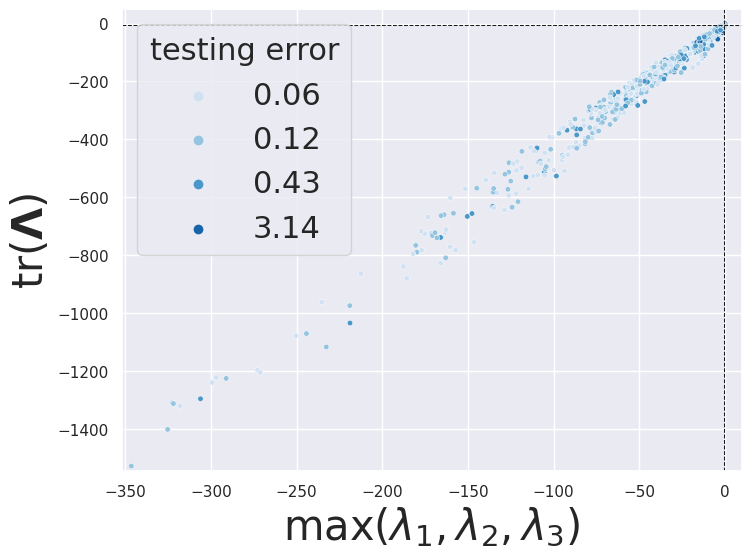

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="max", y="trace", hue='testing error', palette='Blues', s=15)

# Get the current legend
ax.legend(loc=0, fontsize=22)
legend = ax.legend_
legend.set_title("testing error")
legend.get_title().set_fontsize(22)
# Modify the legend labels in-place
for text in legend.get_texts():  # Skip the first label, which is the legend title ('bins')
    value = float(text.get_text())
    new_label = "{:.2f}".format(value)  # Format with 2 decimal places
    text.set_text(new_label)


ax.axvline(df.describe().loc['75%', 'max'], c='k', ls='--', lw=0.75, label='x threshold: \n q=' + '{:.2F}'.format(0.75))
ax.axhline(df.describe().loc['75%', 'trace'], c='k', ls='--', lw=0.75, label='y threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('$\max(\lambda_1, \lambda_2, \lambda_3)$', fontsize=30)
ax.set_ylabel('tr($\mathbf{\Lambda})$', fontsize=30)
ax.set_xlim(np.quantile(lls[0], 0.05), 10)
ax.set_ylim(np.quantile(lls2[0], 0.05), 50)
# Show the plot
plt.show()

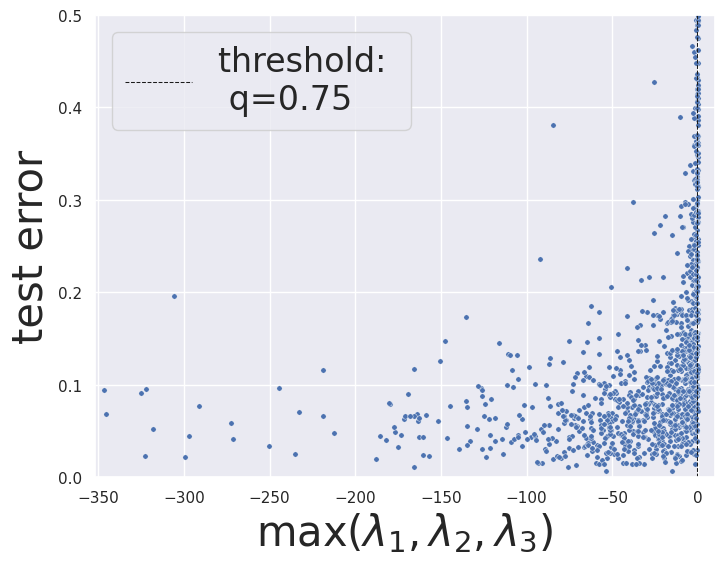

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="max", y="error", s=15)

ax.axvline(df.describe().loc['75%', 'max'], c='k', ls='--', lw=0.75, label='threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('$\max(\lambda_1, \lambda_2, \lambda_3)$', fontsize=30)
ax.set_ylabel('test error', fontsize=30)
ax.set_ylim([0, 0.5])
ax.legend(fontsize=24)
ax.set_xlim(np.quantile(lls[0], 0.05), 10)
# Show the plot
plt.show()

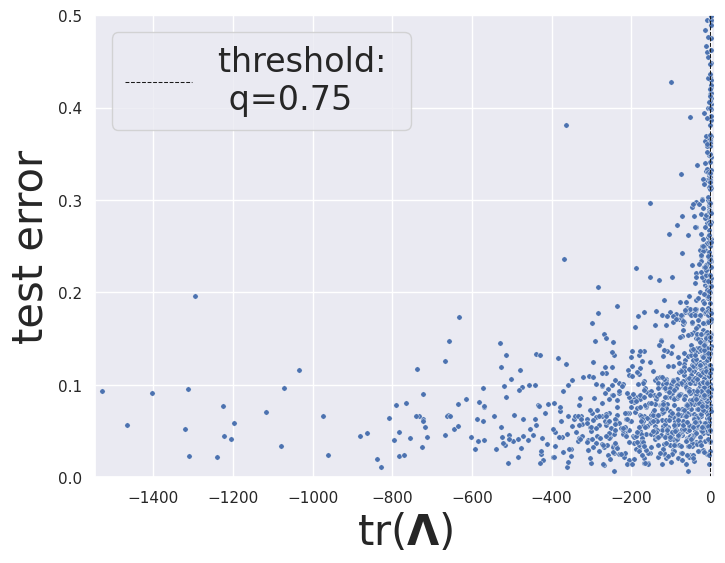

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="trace", y="error", s=15)

ax.axvline(df.describe().loc['75%', 'trace'], c='k', ls='--', lw=0.75, label='threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('tr($\mathbf{\Lambda})$', fontsize=30)
ax.set_ylabel('test error', fontsize=30)
ax.set_ylim([0, 0.5])
ax.legend(fontsize=24)
ax.set_xlim(np.quantile(lls2[0], 0.05), 10)
# Show the plot
plt.show()

### Filter the particles and write out star file

We can construct three distinct `DataFrames` by applying three different filtering schemes based on the Q3 quantile:

In [ ]:
filtered_df = df[(df['max'] < df.describe().loc['75%', 'max']) & (df['trace'] < df.describe().loc['75%', 'trace'])]
filtered_df.describe()

,error,max,trace,gap,likelihood
count,1207.000000,1207.000000,1207.000000,1207.000000,1.207000e+03
mean,0.200706,-198.493595,-882.589153,198.493595,-6.559649e+05
std,0.447809,728.009917,3258.092759,728.009917,3.956181e+06
min,0.006438,-7338.574707,-33406.016846,0.536501,-6.380487e+07
25%,0.052159,-55.732227,-245.326000,4.664256,-3.751985e+03
50%,0.087275,-19.294594,-86.409172,19.294594,-4.814712e+02
75%,0.146117,-4.664256,-26.171422,55.732227,-4.341155e+01
max,3.114995,-0.536501,-3.856088,7338.574707,-2.229257e+00


In [ ]:
filtered_df2 = df[(df['max'] < df.describe().loc['75%', 'max'])]
filtered_df2.describe()

,error,max,trace,gap,likelihood
count,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03
mean,0.208741,-193.697300,-861.263045,193.697300,-6.400563e+05
std,0.458686,719.764332,3221.153792,719.764332,3.909178e+06
min,0.006438,-7338.574707,-33406.016846,0.536501,-6.380487e+07
25%,0.052985,-54.509567,-241.793968,4.221390,-3.492768e+03
50%,0.088796,-17.770676,-82.751566,17.770676,-4.342719e+02
75%,0.150689,-4.221390,-23.301115,54.509567,-3.360418e+01
max,3.114995,-0.536501,-2.111819,7338.574707,-2.229257e+00


In [ ]:
filtered_df3 = df[(df['trace'] < df.describe().loc['75%', 'trace'])]
filtered_df3.describe()

,error,max,trace,gap,likelihood
count,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03
mean,0.218429,-193.687134,-861.316914,193.687134,-6.400564e+05
std,0.471650,719.767063,3221.139459,719.767063,3.909178e+06
min,0.006438,-7338.574707,-33406.016846,0.038711,-6.380487e+07
25%,0.053274,-54.509567,-241.793968,4.221390,-3.492768e+03
50%,0.089176,-17.770676,-82.751566,17.770676,-4.342719e+02
75%,0.153530,-4.221390,-23.301115,54.509567,-3.360418e+01
max,3.114995,-0.038711,-3.804343,7338.574707,-2.229257e+00


We can produce STAR files that encapsulate both the true and predicted orientations for further analysis and comparison:

In [ ]:
qo = quaternion2euler(q_pred_test).numpy()

projections_filename = DATASET_PATH+"70s_real_128_mrali_cs.star"
s = Starfile.load(projections_filename)
df = s.df
df2 = df.iloc[test_idx].copy()
df2['_rlnAngleRot'] = (qo[:,0]/(2*np.pi)*360.0 +360)%360.0
df2['_rlnAngleTilt'] = qo[:,1]/(2*np.pi)*360.0
df2['_rlnAnglePsi'] = (qo[:,2]/(2*np.pi)*360.0 +360)%360.0
df2['_rlnAngleRot'] = df2['_rlnAngleRot'].astype(str)
df2['_rlnAngleTilt'] = df2['_rlnAngleTilt'].astype(str)
df2['_rlnAnglePsi'] = df2['_rlnAnglePsi'].astype(str)

In [ ]:
df3 = df.iloc[test_idx].copy()
df3.head(50)

,_rlnImageName,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi,_rlnOriginXAngst,_rlnOriginYAngst,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle,_rlnPhaseShift,_rlnCtfBfactor,_rlnOpticsGroup,_rlnRandomSubset,_rlnClassNumber
8,000009@mrali2d.mrcs,-53.227058,110.433998,-169.011627,-9.451406,0.400969,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
12,000013@mrali2d.mrcs,-146.650253,141.460510,111.451286,-6.931031,-0.286406,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
14,000015@mrali2d.mrcs,119.636383,69.586823,-75.617043,12.315469,-3.494156,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
17,000018@mrali2d.mrcs,-67.685204,109.749214,-60.273357,0.400969,6.243656,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
19,000020@mrali2d.mrcs,-152.392502,114.332870,106.130669,2.692219,8.191218,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
23,000024@mrali2d.mrcs,116.675034,78.339569,85.118156,6.587344,3.837844,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
26,000027@mrali2d.mrcs,62.647591,20.942657,-122.605194,1.202906,-3.723281,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
29,000030@mrali2d.mrcs,-144.101273,150.837311,112.767654,-0.057281,1.088344,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
30,000031@mrali2d.mrcs,-19.065168,20.045687,130.253036,-3.723281,10.253344,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
31,000032@mrali2d.mrcs,-174.127502,34.561867,115.836121,2.004844,-14.148469,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1


In [ ]:
df2.head(50)

,_rlnImageName,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi,_rlnOriginXAngst,_rlnOriginYAngst,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle,_rlnPhaseShift,_rlnCtfBfactor,_rlnOpticsGroup,_rlnRandomSubset,_rlnClassNumber
8,000009@mrali2d.mrcs,304.88376,109.840096,190.08316,-9.451406,0.400969,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
12,000013@mrali2d.mrcs,216.11984,140.65596,113.385925,-6.931031,-0.286406,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
14,000015@mrali2d.mrcs,122.51697,69.88406,279.2441,12.315469,-3.494156,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
17,000018@mrali2d.mrcs,293.46378,108.25526,302.417,0.400969,6.243656,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
19,000020@mrali2d.mrcs,197.13376,112.11959,104.78931,2.692219,8.191218,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
23,000024@mrali2d.mrcs,124.18848,78.287895,88.52765,6.587344,3.837844,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
26,000027@mrali2d.mrcs,164.5086,9.257755,15.028748,1.202906,-3.723281,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
29,000030@mrali2d.mrcs,217.03433,150.38457,113.53824,-0.057281,1.088344,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1
30,000031@mrali2d.mrcs,333.33453,16.118158,139.44891,-3.723281,10.253344,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1
31,000032@mrali2d.mrcs,193.9934,52.972374,94.33096,2.004844,-14.148469,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1


To ensure compatibility with `cryoSPARC`, we will append additional columns to the STAR files as follows:

In [ ]:
df2['_rlnAmplitudeContrast'] = 0.150000
df2['_rlnSphericalAberration'] = 2.000000
df2['_rlnVoltage'] = 200.000000
df2['_rlnAmplitudeContrast'] = df2['_rlnAmplitudeContrast'].astype(str)
df2['_rlnSphericalAberration'] = df2['_rlnSphericalAberration'].astype(str)
df2['_rlnVoltage'] = df2['_rlnVoltage'].astype(str)
s2 = Starfile(df2.columns, df2)
s2.write('70sreal_new2.star')

In [ ]:
df3['_rlnAmplitudeContrast'] = 0.150000
df3['_rlnSphericalAberration'] = 2.000000
df3['_rlnVoltage'] = 200.000000
df3['_rlnAmplitudeContrast'] = df3['_rlnAmplitudeContrast'].astype(str)
df3['_rlnSphericalAberration'] = df3['_rlnSphericalAberration'].astype(str)
df3['_rlnVoltage'] = df3['_rlnVoltage'].astype(str)
s3 = Starfile(df3.columns, df3)
s3.write('70sreal_true2.star')

> Be sure to tailor the optical settings to match the specifications of your dataset.

We will also create filtered STAR files that exclude outliers based on the three predefined filtering schemes:

In [ ]:
df10 = df2.iloc[filtered_df.index.values].copy()

In [ ]:
df10['_rlnAmplitudeContrast'] = 0.150000
df10['_rlnSphericalAberration'] = 2.000000
df10['_rlnVoltage'] = 200.000000
df10['_rlnAmplitudeContrast'] = df10['_rlnAmplitudeContrast'].astype(str)
df10['_rlnSphericalAberration'] = df10['_rlnSphericalAberration'].astype(str)
df10['_rlnVoltage'] = df10['_rlnVoltage'].astype(str)
s10 = Starfile(df10.columns, df10)
s10.write('70sreal_sel_mt.star')

In [ ]:
df11 = df2.iloc[filtered_df2.index.values].copy()

In [ ]:
df11['_rlnAmplitudeContrast'] = 0.150000
df11['_rlnSphericalAberration'] = 2.000000
df11['_rlnVoltage'] = 200.000000
df11['_rlnAmplitudeContrast'] = df11['_rlnAmplitudeContrast'].astype(str)
df11['_rlnSphericalAberration'] = df11['_rlnSphericalAberration'].astype(str)
df11['_rlnVoltage'] = df11['_rlnVoltage'].astype(str)
s11 = Starfile(df11.columns, df11)
s11.write('70sreal_sel_m.star')

In [ ]:
df12 = df2.iloc[filtered_df3.index.values].copy()

In [ ]:
df12['_rlnAmplitudeContrast'] = 0.150000
df12['_rlnSphericalAberration'] = 2.000000
df12['_rlnVoltage'] = 200.000000
df12['_rlnAmplitudeContrast'] = df12['_rlnAmplitudeContrast'].astype(str)
df12['_rlnSphericalAberration'] = df12['_rlnSphericalAberration'].astype(str)
df12['_rlnVoltage'] = df12['_rlnVoltage'].astype(str)
s12 = Starfile(df12.columns, df12)
s12.write('70sreal_sel_t.star')

In [ ]:
df2

,_rlnImageName,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi,_rlnOriginXAngst,_rlnOriginYAngst,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle,_rlnPhaseShift,_rlnCtfBfactor,_rlnOpticsGroup,_rlnRandomSubset,_rlnClassNumber,_rlnAmplitudeContrast,_rlnSphericalAberration,_rlnVoltage
8,000009@mrali2d.mrcs,304.88376,109.840096,190.08316,-9.451406,0.400969,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1,0.15,2.0,200.0
12,000013@mrali2d.mrcs,216.11984,140.65596,113.385925,-6.931031,-0.286406,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1,0.15,2.0,200.0
14,000015@mrali2d.mrcs,122.51697,69.88406,279.2441,12.315469,-3.494156,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,1,1,0.15,2.0,200.0
17,000018@mrali2d.mrcs,293.46378,108.25526,302.417,0.400969,6.243656,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1,0.15,2.0,200.0
19,000020@mrali2d.mrcs,197.13376,112.11959,104.78931,2.692219,8.191218,21580.000000,21580.000000,0.000000,0.000000,0.000000,3,2,1,0.15,2.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,004991@mrali2d.mrcs,114.42667,83.47722,170.05066,3.723281,0.859219,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,1,1,0.15,2.0,200.0
4995,004996@mrali2d.mrcs,140.5622,4.66073,341.16766,3.379594,4.868906,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,2,1,0.15,2.0,200.0
4996,004997@mrali2d.mrcs,344.77817,151.14177,25.733856,-7.160156,12.544594,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,1,1,0.15,2.0,200.0
4998,004999@mrali2d.mrcs,321.32755,52.67831,270.36176,-6.358219,1.890281,34588.000000,34588.000000,0.000000,0.000000,0.000000,3,1,1,0.15,2.0,200.0


This additional analysis will delve into the discrepancies between the true orientations (`df3`) and the predicted orientations (`df2`):

In [ ]:
df4 = df2.loc[:,'_rlnAngleRot':'_rlnAnglePsi'].astype(float) - df3.loc[:,'_rlnAngleRot':'_rlnAnglePsi'].astype(float)

In [ ]:
a1 = df4['_rlnAnglePsi']%360
a2 = df4['_rlnAngleRot']%360
a3 = df4['_rlnAngleTilt']%180

b1 = a1.values
b2 = a2.values
b3 = a3.values

In [ ]:
c1 = np.where(b1 <180, b1, 360-b1)
c2 = np.where(b2 <180, b2, 360-b2)
c3 = np.where(b3 <90, b3, 180-b3)

df4['_rlnAnglePsi_a'] = c1
df4['_rlnAngleRot_a'] = c2
df4['_rlnAngleTilt_a'] = c3

In [ ]:
df4

,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi,_rlnAnglePsi_a,_rlnAngleRot_a,_rlnAngleTilt_a
8,358.110818,-0.593902,359.094787,0.905213,1.889182,0.593902
12,362.770093,-0.804550,1.934639,1.934639,2.770093,0.804550
14,2.880587,0.297237,354.861143,5.138857,2.880587,0.297237
17,361.148984,-1.493954,362.690357,2.690357,1.148984,1.493954
19,349.526262,-2.213280,-1.341359,1.341359,10.473738,2.213280
...,...,...,...,...,...,...
4990,-8.398647,8.314050,-1.855895,1.855895,8.398647,8.314050
4995,34.476018,-8.970917,327.056986,32.943014,34.476018,8.970917
4996,391.944888,84.358559,18.408163,18.408163,31.944888,84.358559
4998,356.356397,0.115348,361.894803,1.894803,3.643603,0.115348


In [ ]:
df4.describe()

,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi,_rlnAnglePsi_a,_rlnAngleRot_a,_rlnAngleTilt_a
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,227.467909,1.694802,167.932730,16.914136,25.220709,11.582146
std,166.672384,32.449836,175.217266,32.451331,41.239252,19.046195
min,-165.080963,-162.266534,-111.089951,0.011729,0.008525,0.000570
25%,11.620748,-3.790851,0.212784,1.625746,2.437008,1.526446
50%,346.824863,-0.351576,68.153753,4.329694,6.406916,3.589906
75%,360.207323,3.268531,358.372057,13.353660,22.905450,10.176712
max,500.975643,160.731413,447.659011,179.858421,179.881208,89.677653
